# Analýza zákazníků

Máme k dispozici seznam zákazníků s jejich osobními informacemi a jejich chováním.

Na trh chceme uvést nový luxusní a drahý výrobek. 

Na které zákazníky máme zaměřit personalizovaný marketing?

# Úkol
- Proveďte základní analýzu dat a jejich vizualizaci
- Proveďte úpravu dat (encoding)
- Vyberte vhodné proměnné, podle kterých půjdou zákazníci segmentovat
- Vytvořte k-mean model s vhodným počtem segmentů
- Vizualizujte model
- Který segment je cílový?

# Načtení dat

In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  

In [32]:
data=pd.read_csv('..\\dataset\\Mall_Customers.csv')

# Popis  dat
- informace o datech
- náhled na data
- základní statistika
- zobrazení distribuce dat

In [33]:
data.info()
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [34]:
data.head(10)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


C:\Users\kobrl\AppData\Local\Temp\ipykernel_14556\1411576675.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Annual Income (k$)'], shade=True, color='blue', label='Annual Income')
C:\Users\kobrl\AppData\Local\Temp\ipykernel_14556\1411576675.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Spending Score (1-100)'], shade=True, color='green', label='Spending Score')


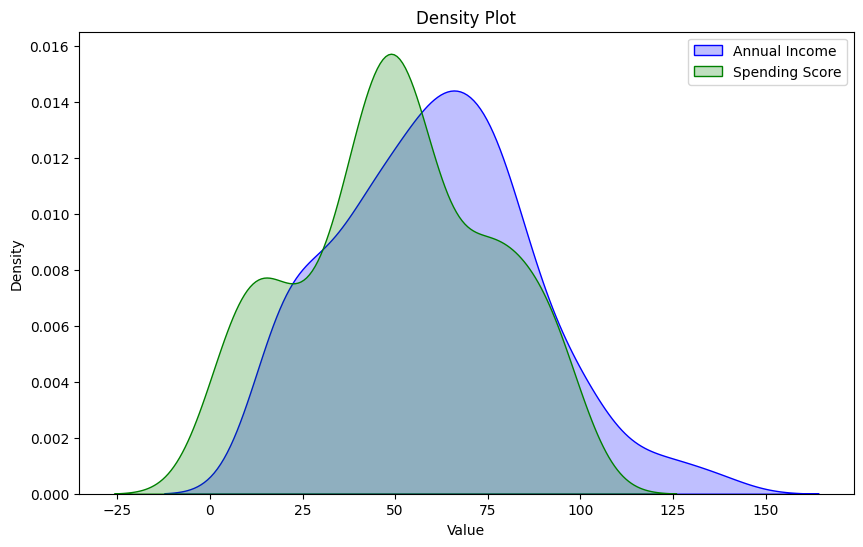

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(data['Annual Income (k$)'], shade=True, color='blue', label='Annual Income')
sns.kdeplot(data['Spending Score (1-100)'], shade=True, color='green', label='Spending Score')
plt.title('Density Plot')
plt.xlabel('Value')
plt.legend()
plt.show()


# Příprava dat
- ošetření NaN hodnot
- encodování textových sloupců

In [36]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [37]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['species_enc']=label_encoder.fit_transform(data['Spending Score (1-100)'])

In [38]:
# Uložení encoderu pro opakované použití
import joblib
joblib.dump(label_encoder, 'classification_encoder.bin', compress=True)

['classification_encoder.bin']

In [39]:
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),species_enc
0,1,Male,19,15,39,30
1,2,Male,21,15,81,67
2,3,Female,20,16,6,4
3,4,Female,23,16,77,64
4,5,Female,31,17,40,31
...,...,...,...,...,...,...
195,196,Female,35,120,79,66
196,197,Female,45,126,28,23
197,198,Male,32,126,74,61
198,199,Male,32,137,18,16


In [40]:
# lepší ukázka dat
pd.concat([data.iloc[0:2], data.iloc[60:62], data.iloc[120:122]])

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),species_enc
0,1,Male,19,15,39,30
1,2,Male,21,15,81,67
60,61,Male,70,46,56,47
61,62,Male,19,46,55,46
120,121,Male,27,67,56,47
121,122,Female,38,67,40,31


# Výběr proměnných
- zobrazení vztahů mezi proměnnými (pairplot)
- hledáme kombinaci proměnných, které lze opticky ropzdělit do skupin
- vytvoření X pouze s těmito sloupci

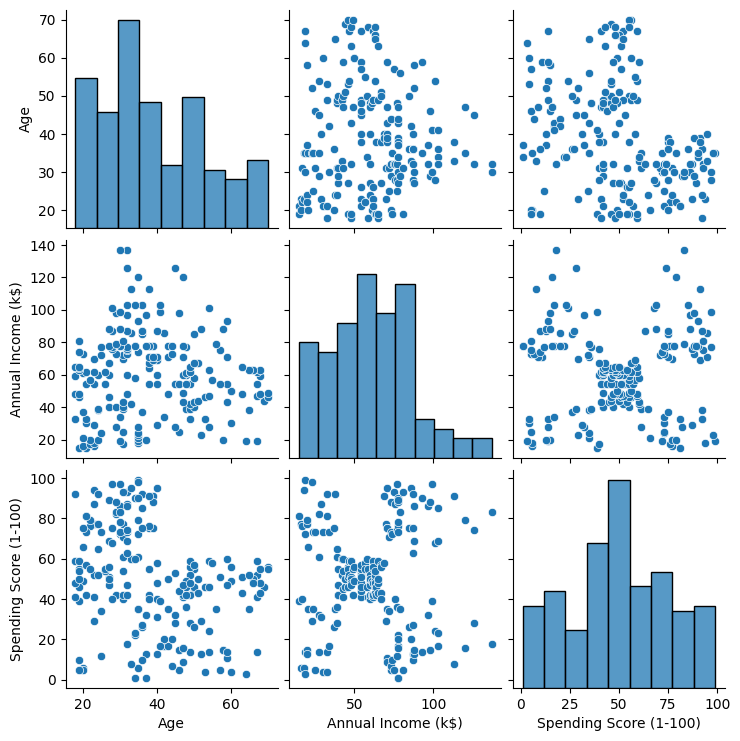

In [41]:
sns.pairplot(data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.show()


In [42]:
X = data[['Annual Income (k$)', 'Spending Score (1-100)']].values
Y = data['species_enc']


# Zjištění parametru modelu k-mean
- vykreslení elbow grafu
- zjištění ideálního počtu clusterů

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris


In [44]:
from sklearn.preprocessing import StandardScaler


In [45]:
scaler=StandardScaler()
X_norm=scaler.fit_transform(X)

In [46]:
# natrénovaný scaler si uložíme do souboru
# při hledání druhu kosatce budeme muset vstupní data normalizovat stejně jako jsme je normalizovali během trénování
import joblib
joblib.dump(scaler, 'classification_std_scaler.bin', compress=True)
scaler=joblib.load('classification_std_scaler.bin')

In [47]:
X_feature=X[:,0]*X[:,1]

In [48]:
# připravená data si uložení do numpy souboru, abychom tuto činnost nemuseli v dalších noteboocích opakovat
np.savez ("iris_numpy", X, Y, X_norm, X_feature)

Text(0.5, 1.0, 'Different Inertia Values for Different Number of Clusters')

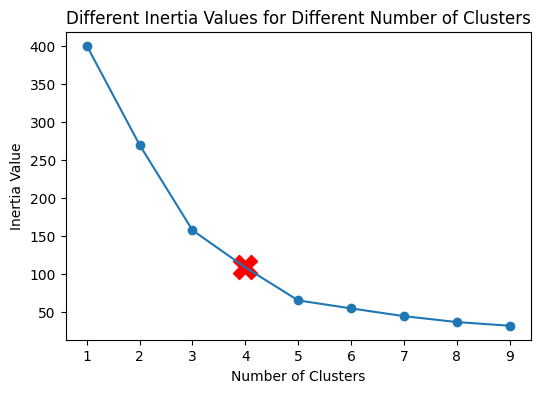

In [49]:



from sklearn.cluster import KMeans
inertia_list = []
for num_clusters in range(1, 10):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++", n_init = 10)
    kmeans_model.fit(X_norm)
    inertia_list.append(kmeans_model.inertia_)

# Vhodné k zjistíme vynesením interial_ do elbow (loket) grafu
# Optimální počet k je v místě, kde se graf naposledy výrazně láme

plt.figure(figsize=(6,4))
plt.plot(range(1,10),inertia_list)
plt.scatter(range(1,10),inertia_list)
plt.scatter(4, inertia_list[3], marker="X", s=300, c="r")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Value")
plt.title("Different Inertia Values for Different Number of Clusters")


In [50]:
# Předpokládejme, že ideální počet clusterů je 3
kmeans_model = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_model.fit(X)


KMeans(n_clusters=4, random_state=42)

# k-mean model pro zjištěný počet clusterů
- natrénování modelu
- predikce dat

In [51]:
predicted_labels = kmeans_model.predict(X)


# Vizualizace modelu
- vykreslení obarvených skupin grafů

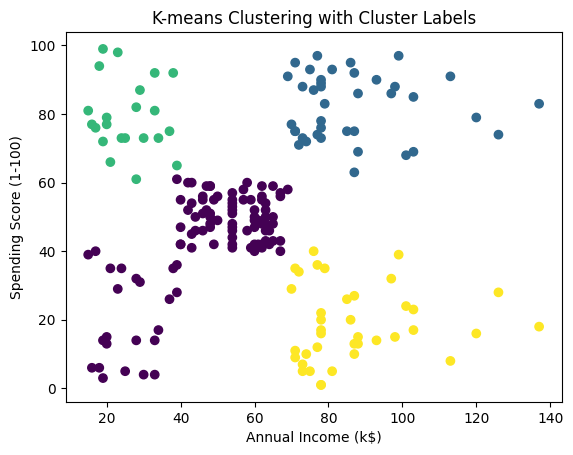

In [52]:
# Vizualizace clusterů
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels)
# Popisky grafu
plt.title('K-means Clustering with Cluster Labels')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

## Výklad modelu
- Popište jednotlivé skupiny
- Na jaké zákazníky se zaměřit?

Cluster 1: Zákazníci s nízkým příjmem a nízkým skóre utrácení.

Cluster 2: Zákazníci se středním příjmem a středním skóre utrácení.

Cluster 3: Zákazníci s vysokým příjmem a vysokým skóre utrácení.

Pro nový luxusní produkt byste se měli zaměřit na zákazníky v Clusteru 3, kteří mají nejvyšší příjmy a nejvyšší skóre utrácení. 